In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Overview
Use this notebook to convert an OCT image you have to an H&E image in order to evaluate how the code works.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/zero_shot_segmentation/blob/main/Histology_mask_generator_using_sam.ipynb)
 and run.


# inputs to script

In [ ]:
# Path to an OCT image to convert
oct_input_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/Emilie/cropped image.png"




#assumptions:

In [ ]:
#how many microns per pixel for each axis
microns_per_pixel_z = 1
microns_per_pixel_x = 1

#pix2pix input sizes
VIRTUAL_HIST_WIDTH = 256
VIRTUAL_HIST_HEIGHT = 256
#verify input sizes
MICRONS_PER_PIXEL_Z_TARGET = 1
MICRONS_PER_PIXEL_X_TARGET = 2

#get images

In [ ]:
import os

# Clone repository
!git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-UseModel

base_folder = "/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix"

# Install dependencies
!pip install -r {base_folder}/requirements.txt

# Clean up this window once install is complete
from IPython.display import clear_output
clear_output()

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')
oct_image_orig = cv2.imread(oct_input_image_path)


In [ ]:
%cd /content/OCT2Hist-UseModel
from utils.masking_utils import mask_image
preprocessed_img = mask_image(oct_image)

In [ ]:
target_rate_img = cv2.resize(img, (new_image_width, new_image_height), interpolation=cv2.INTER_AREA)
o2h_input = np.zeros((VIRTUAL_HIST_HEIGHT,VIRTUAL_HIST_WIDTH, 3),dtype=np.uint8)
o2h_input[:new_image_height, :new_image_width,:] = target_rate_img

In [ ]:
# Perform pre-process
oct_image_preprocessed = o2h_input

# Show image to user
oct_image_preprocessed_shape = oct_image_preprocessed.shape
axes[1].imshow(oct_image)
axes[1].axis("off")
axes[1].set_title(f"Preprocessed OCT image ({oct_image_preprocessed_shape})")
plt.show()

#run oct2hist

In [ ]:
# Create a folder and place OCT image
!mkdir {base_folder}/dataset
!mkdir {base_folder}/dataset/test/

# Before writting image to file, check size
if oct_image_preprocessed.shape[:2] != (256, 256):
        raise ValueError("Image size must be 256x256 pixels to run model on.")

# Padd image and write it to the correct place
padded = np.zeros([256,512,3], np.uint8)
padded[:,:256,:] = oct_image_preprocessed[:,:,:]
cv2.imwrite(f"{base_folder}/dataset/test/im1.jpg", padded)

In [ ]:
!python {base_folder}/test.py --netG resnet_9blocks --dataroot "{base_folder}/dataset/"  --model pix2pix --name pix2pix --checkpoints_dir "{base_folder}/checkpoints" --results_dir "{base_folder}/results"

In [ ]:
# Load the virtual histology image
histology_image = cv2.imread(f"{base_folder}/results/pix2pix/test_latest/images/im1_fake_B.png")
histology_image = cv2.cvtColor(histology_image, cv2.COLOR_BGR2RGB)

# present side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(oct_image)
axes[0].axis("off")
axes[0].set_title("OCT")
axes[1].imshow(histology_image)
axes[1].axis("off")
axes[1].set_title("Virtual Histology")
plt.show()


In [ ]:
height,width = preprocessed_img.shape[:2]
histology_image_resized = cv2.resize(histology_image, [width,height] , interpolation=cv2.INTER_AREA)
print(histology_image_resized.shape)


In [ ]:
from utils.img_utils import showTwoImgs
#visualize

# present side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(preprocessed_img)
axes[0].axis("off")
axes[0].set_title("OCT")
axes[1].imshow(histology_image_resized)
axes[1].axis("off")
axes[1].set_title("Virtual Histology")
plt.show()

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

# This is the folder that the pre-trained model is in
model_folder = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Model (Paper V2)"

# Copy model to this folder over
!mkdir {base_folder}/checkpoints
!mkdir {base_folder}/checkpoints/pix2pix/
!cp "{model_folder}/latest_net_G.pth" {base_folder}/checkpoints/pix2pix/
!cp "{model_folder}/latest_net_D.pth" {base_folder}/checkpoints/pix2pix/

#run sam on virtual histology

#project on oct

In [ ]:
#util functions were taken from https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb#scrollTo=dZSU9BpHr2gc
!pip install dataclasses-json
!pip install supervision

import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = True

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="R04BinsZcBZ6PsfKR2fP")
project = rf.workspace("yolab-kmmfx").project("connect_from_colab")
dataset = project.version(1).download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to connect_from_colab-1 in png-mask-semantic:: 100%|██████████| 6/6 [00:00<00:00, 758.76it/s]


In [ ]:
import os
DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)
print(IMAGES_DIRECTORY_PATH)
print(ANNOTATIONS_FILE_PATH)

/content/connect_from_colab-1/test
/content/connect_from_colab-1/test/_annotations.coco.json


In [ ]:
# coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

# CLASSES = [
#     category.name
#     for category
#     in coco_data.categories
#     if category.supercategory != 'none'
# ]

# IMAGES = [
#     image.file_name
#     for image
#     in coco_data.images
# ]

In [ ]:
# print(CLASSES, IMAGES)

In [ ]:
if using_colab:

  import torch
  import torchvision
  print("PyTorch version:", torch.__version__)
  print("Torchvision version:", torchvision.__version__)
  print("CUDA is available:", torch.cuda.is_available())
  import sys
  !{sys.executable} -m pip install opencv-python matplotlib
  !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  !mkdir images
  !wget -P images https://pbs.twimg.com/media/FvpQj7UWYAAgxfo?format=jpg&name=large
#https://twitter.com/JMGardnerMD/status/1655724394805706752/photo/1
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-z39r6gmo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-z39r6gmo
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘images’: File exists
--2023-07-26 22:44:45--  https://pbs.twimg.com/media/FvpQj7UWYAAgxfo?format=jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 72.21.91.70, 2a04:4e42:5::159
Connecting to pbs.twimg.com (pbs.twimg.com)|72.21.91.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254202 (248K) [image/jpeg]
Saving to: ‘images/FvpQj7UWYAAgxfo?format=jpg.1’

FvpQj7UWYAAgxfo?for 100%[===================>] 248.24K  --.-KB/s    in 0.02s   

2023-07-26 22:44:45 (

In [ ]:
# dir_name = 'images_to_stitch'
# output_dir_name = 'stiched_output'
# images_to_stitch_fnames = os.listdir(dir_name)
# images_to_stitch_jpgs = [f for f in images_to_stitch_fnames if (f.endswith('.jpg')| f.endswith(".tiff"))]
# images_to_stitch_jpgs.sort()
# print(images_to_stitch_jpgs)


In [ ]:
import cv2

In [ ]:
# from pickleshare import print_function

# def filename_to_img(f):
#   path=f'{dir_name}/{f}'
#   print(path)
#   im = cv2.imread(path)
#   return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)


# print(images_to_stitch_jpgs)
# images = [filename_to_img(f) for f in images_to_stitch_jpgs ]
# # for fname in images_to_stitch:

# #read images

# image2 = cv2.imread('images/im2.jpg')
# image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
# image3 = cv2.imread('images/im3.jpg')
# image3 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
# image4 = cv2.imread('images/im4.jpg')
# image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)





In [ ]:
#define affine transformation
# M = np.float32([
# 	[1, 0, -50],
# 	[0, 1, 0]
# ])

# shifted = cv2.warpAffine(image2, M, (image2.shape[1], image2.shape[0]))


In [ ]:
# print(image1.shape[0], image1.shape[1])
# print(image2.shape[0], image2.shape[1])
# print(shifted.shape[0], shifted.shape[1])
# print(shifted.dtype)

In [ ]:
# #show them text to each other
# n_images = len(images)
# overlap_size = 50;
# y_axis_drift = 1;




In [ ]:
# image_width = images[0].shape[1];
# image_height = images[0].shape[0];
# n_images = len(images_to_stitch_jpgs)
# new_width = n_images * image_width - (n_images-1)*overlap_size;
# stitched_image = np.zeros((image_height ,new_width,3), np.uint8);


In [ ]:
# print(stitched_image.shape)
# print(type(stitched_image))
# print(image_width,image_height)
# print(len(images))

In [ ]:
#write into images
# next_start_col=0;
# next_end_col=image_width;
# next_start_row = 0;
# next_row_offset = 0;
# next_column_offset = 50;
# next_row_offset_drift = 2;

# for im in images:
#   stitched_image[:image_height-next_row_offset ,next_start_col:next_end_col] = im[next_row_offset:,:];
#   next_start_col = next_end_col - next_column_offset;
#   next_end_col = next_start_col + image_width;
#   next_row_offset += next_row_offset_drift;

# filename = f"{output_dir_name}/imgCat.jpg"
# cv2.imwrite(filename, stitched_image)


In [ ]:
#if we didn't register
# concat_imgs = np.concatenate((image1, image2,image3,image4), axis=1)


In [ ]:
# concat_imgs.shape

In [ ]:
import supervision as sv

## Set-up

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):

  if len(anns) == 0:
    return
  sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
  ax = plt.gca()
  ax.set_autoscale_on(False)

  img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
  img[:,:,3] = 0
  for ann in sorted_anns:
      m = ann['segmentation']
      color_mask = np.concatenate([np.random.random(3), [0.35]])
      img[m] = color_mask
  ax.imshow(img)

## Example image

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
type(dataset)

roboflow.core.dataset.Dataset

In [ ]:
# !mv './images/FvpQj7UWYAAgxfo?format=jpg' './images/histology.jpg'
image = cv2.imread('/content/images/input_to_segment_anything.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

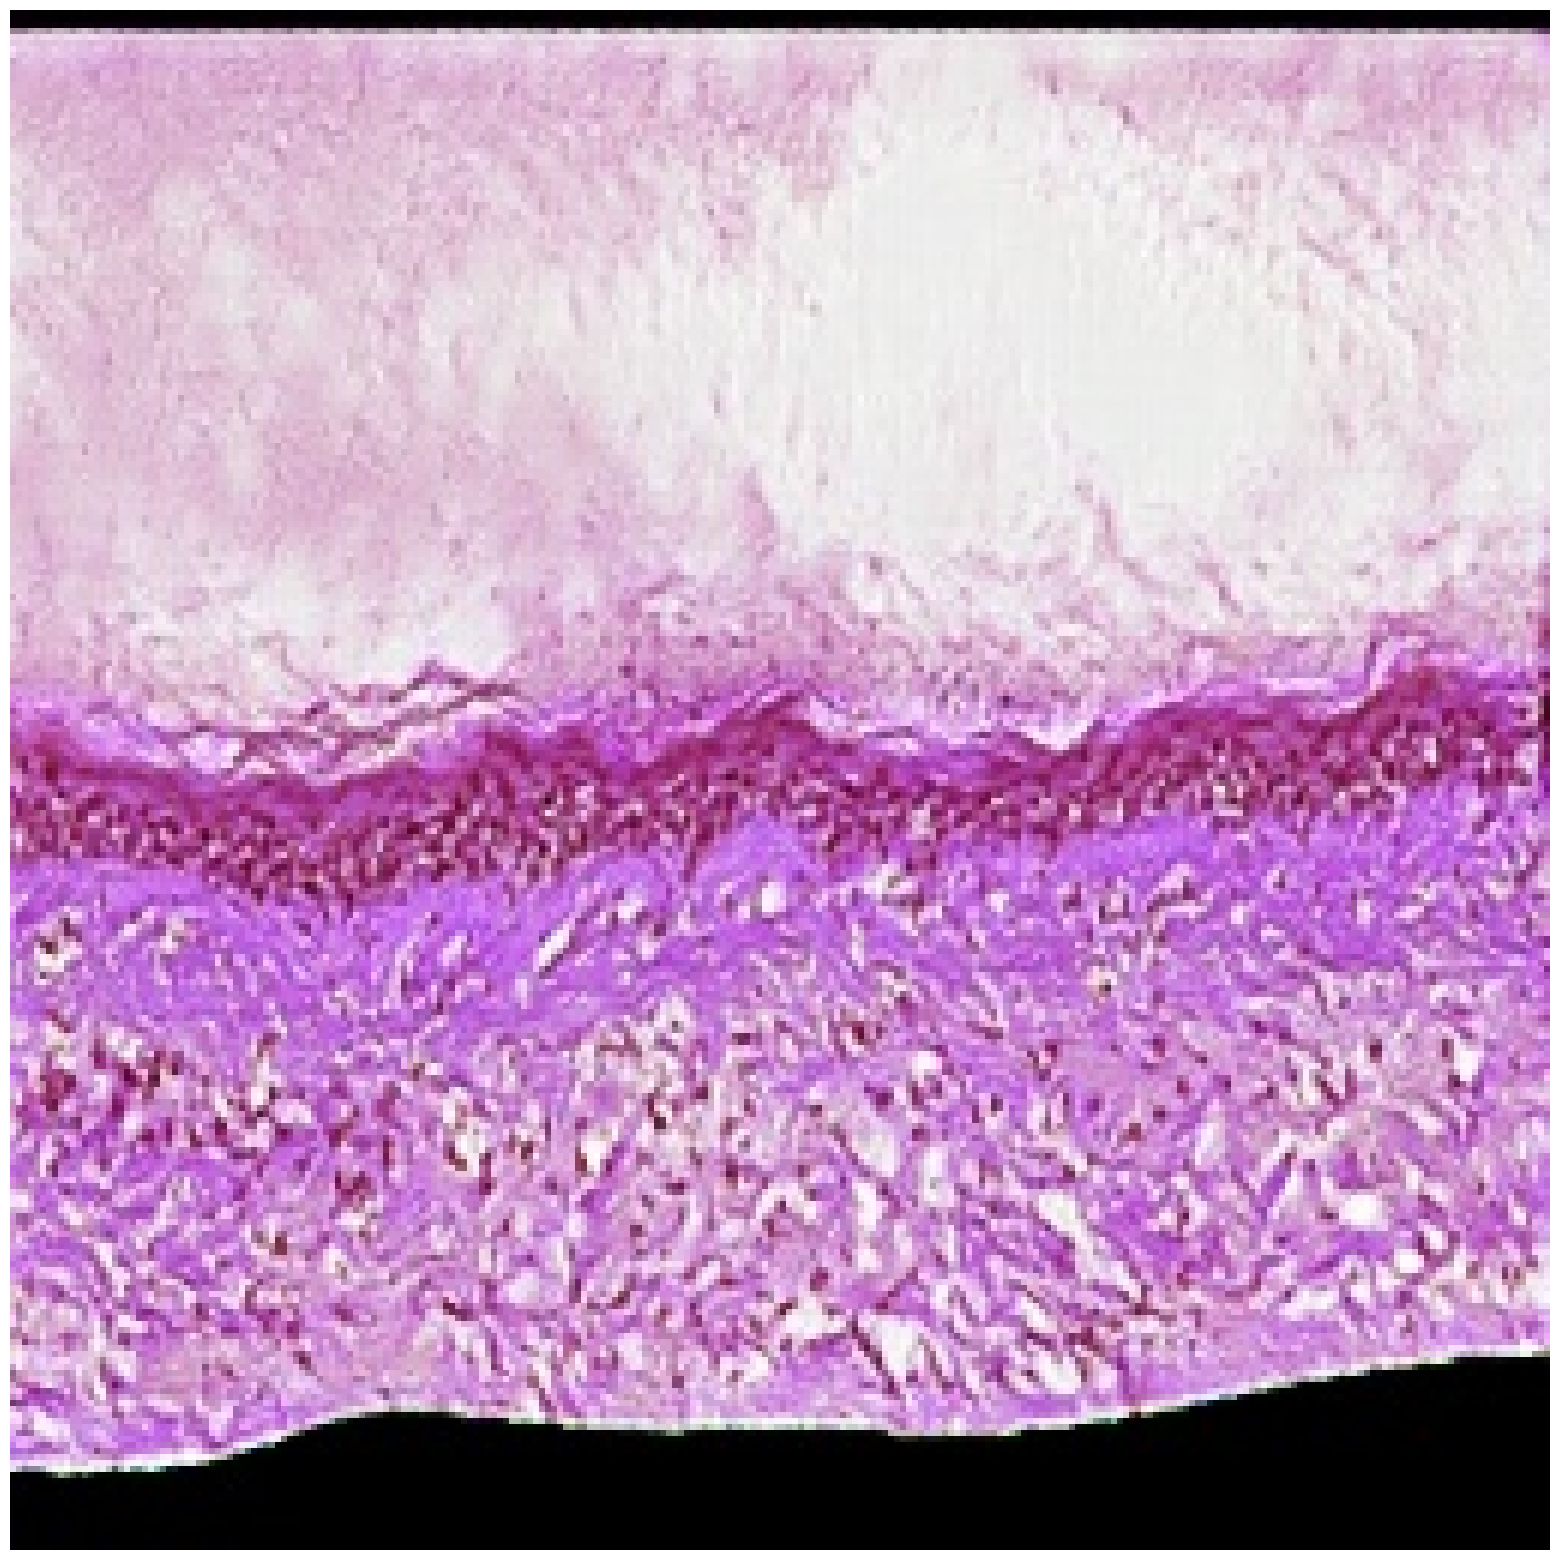

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()


## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [ ]:
masks = mask_generator.generate(image)

In [ ]:
print(image.shape)

(256, 256, 3)


Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())
print(masks[0])
print(masks[0]['segmentation'].shape)

13
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 28172, 'bbox': [0, 4, 255, 117], 'predicted_iou': 0.9962230920791626, 'point_coords': [[156.0, 36.0]], 'stability_score': 0.9641449451446533, 'crop_box': [0, 0, 256, 256]}
(256, 256)


Show all the masks overlayed on the image.

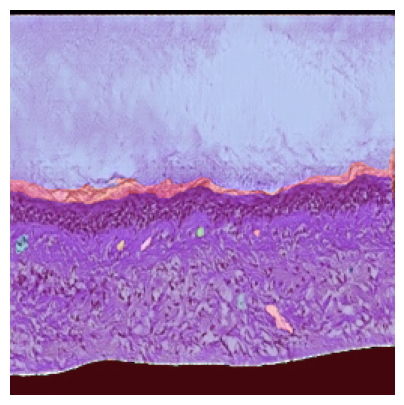

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

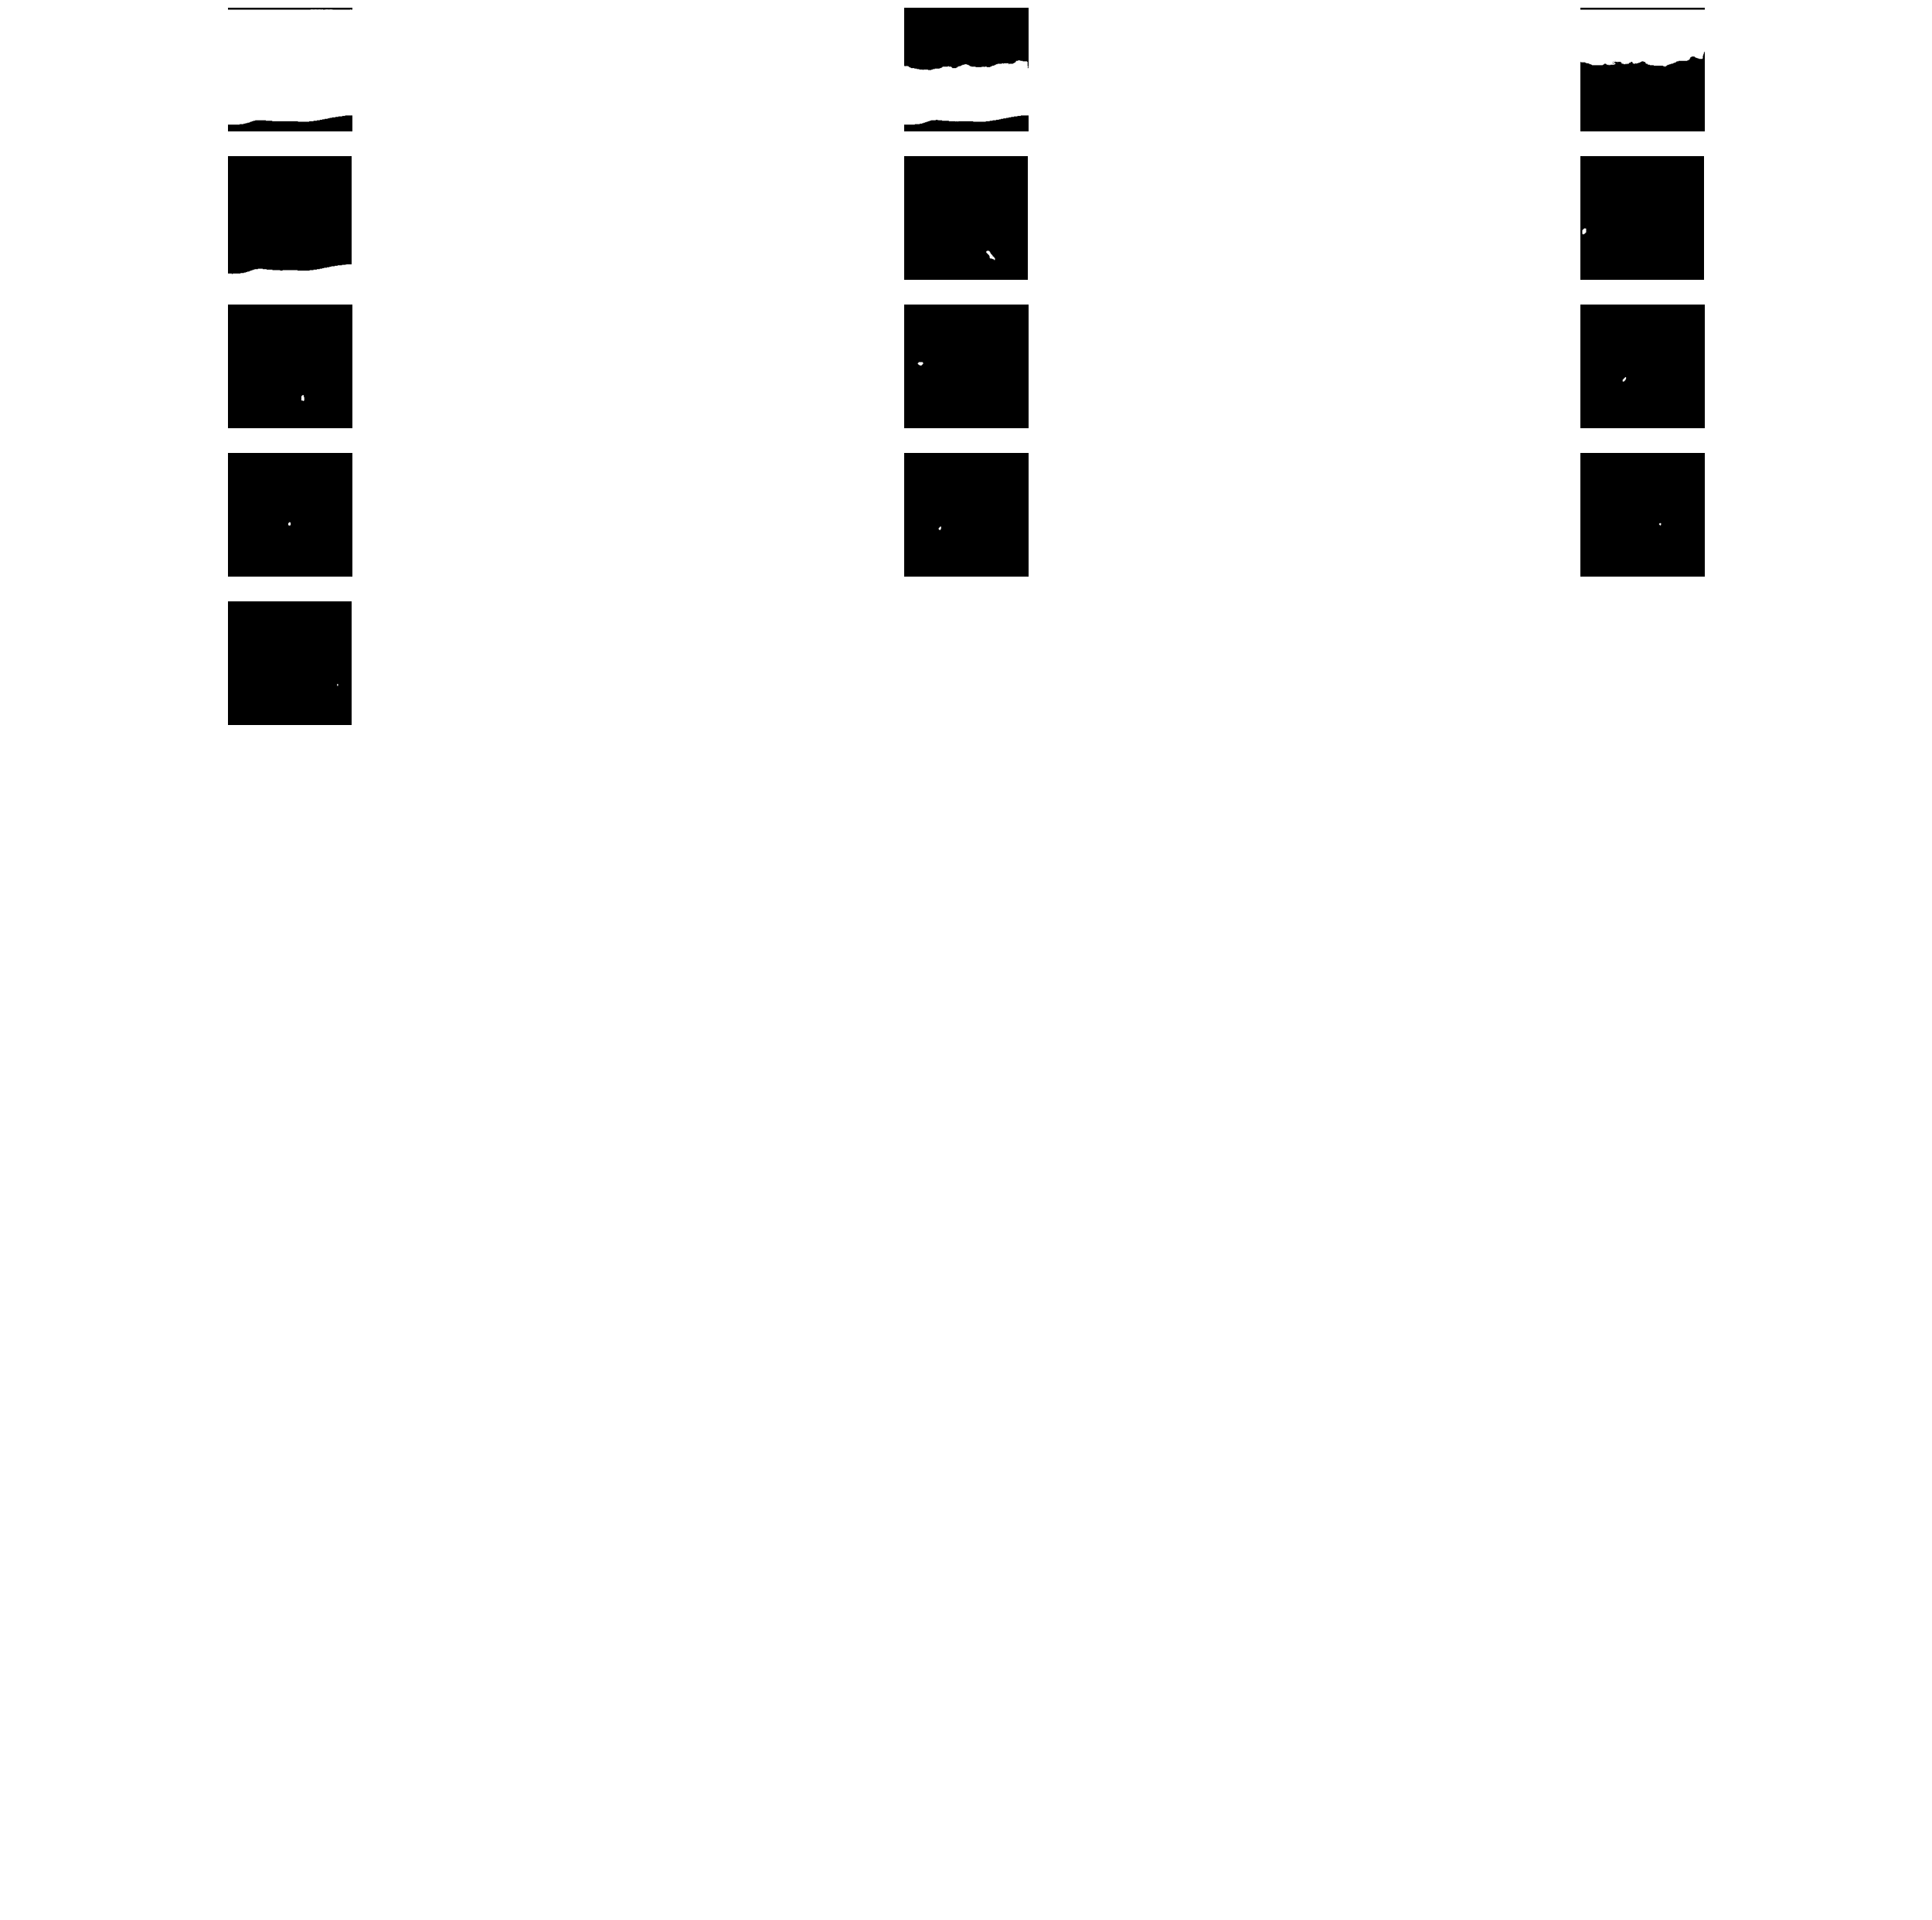

In [ ]:

boolean_masks = [
    mask['segmentation']
    for mask
    in sorted(masks, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=boolean_masks,
    grid_size=(len(masks), int(len(boolean_masks) / 4)),
    size=(32, 32)
)

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:[link text](https://)


In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    # points_per_side=32,
    pred_iou_thresh=0.90,
    stability_score_thresh=0.95,
    # crop_n_layers=1,
    # crop_n_points_downscale_factor=2,
    min_mask_region_area=3000,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

12

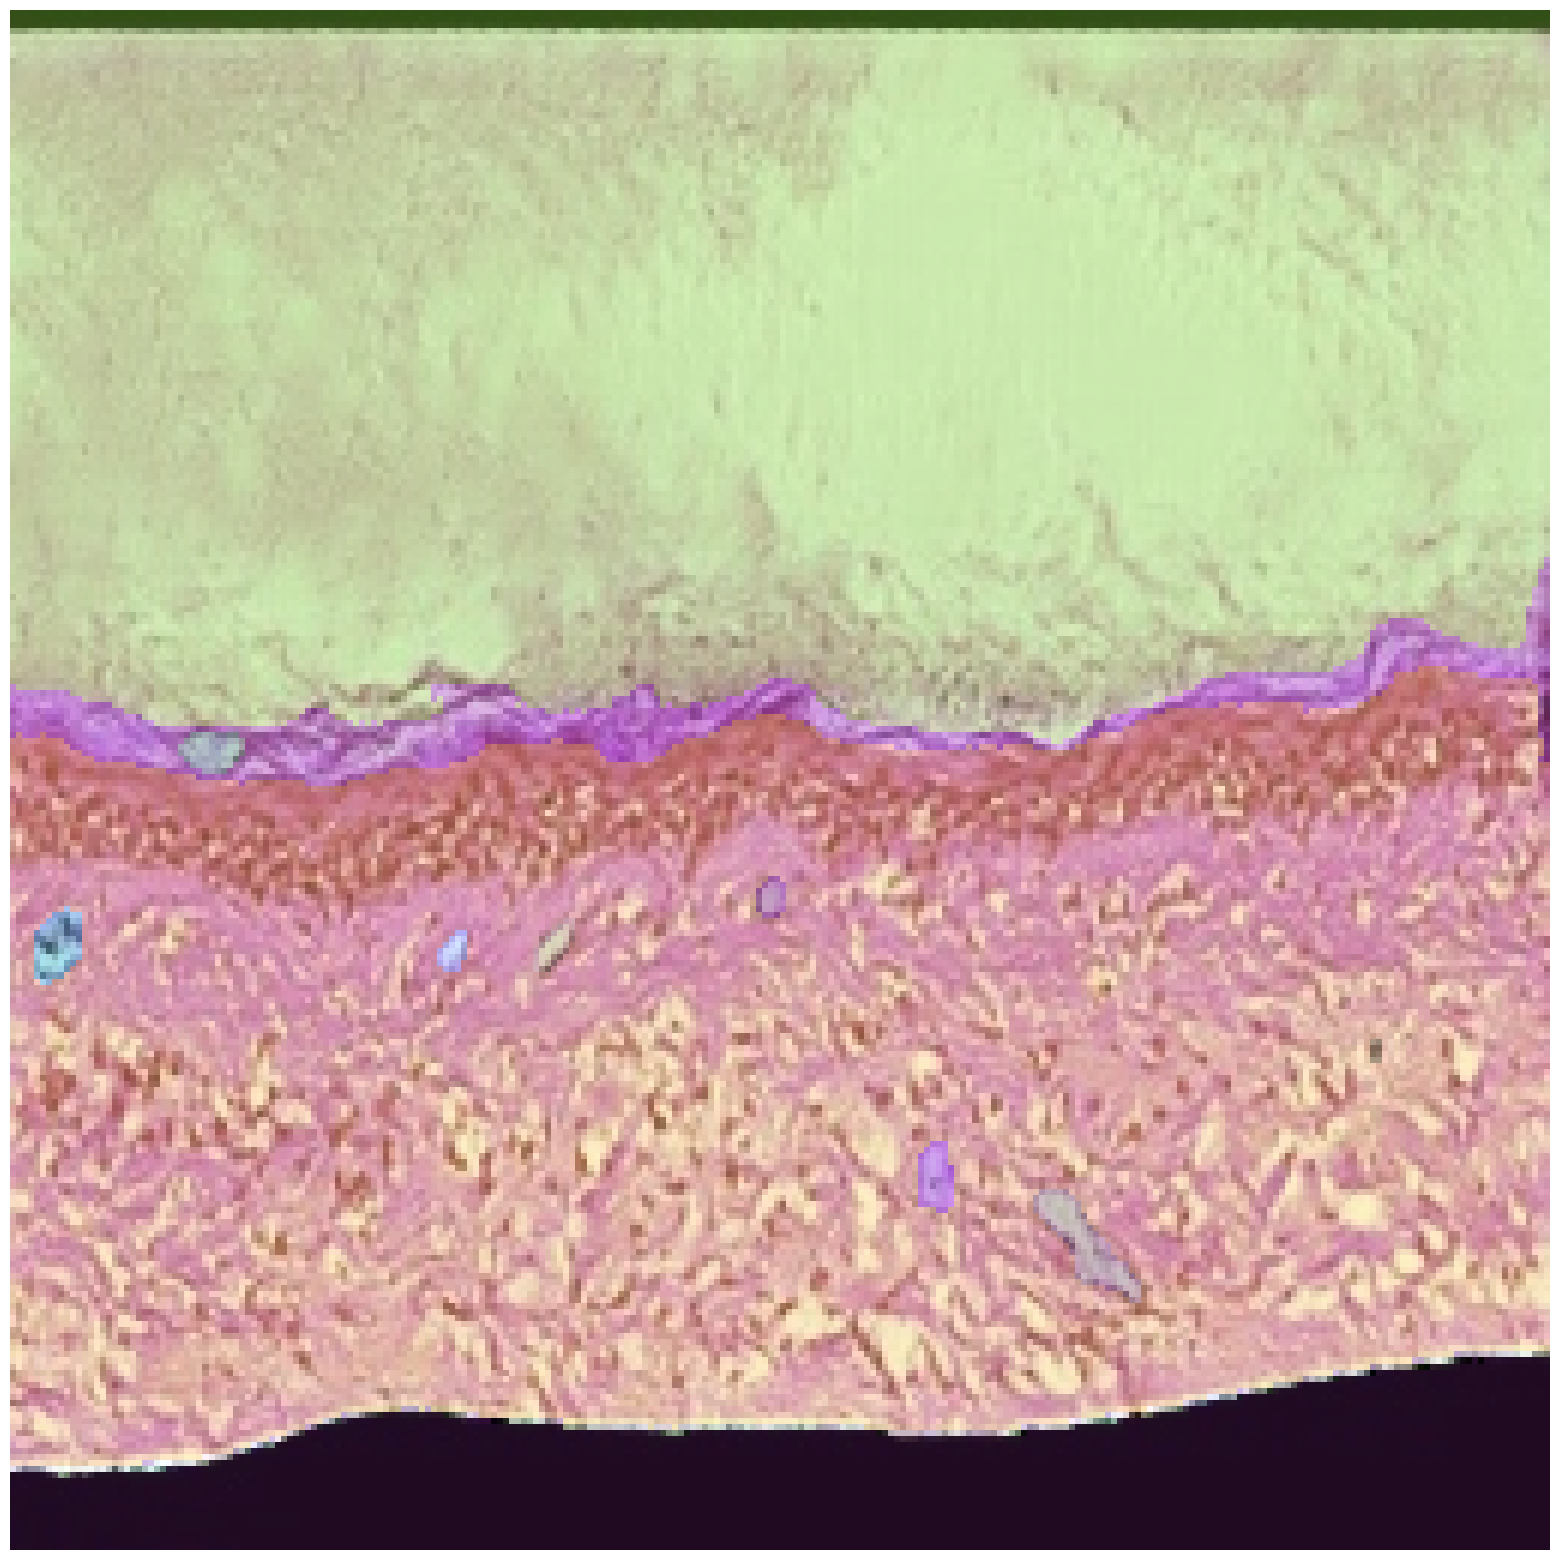

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

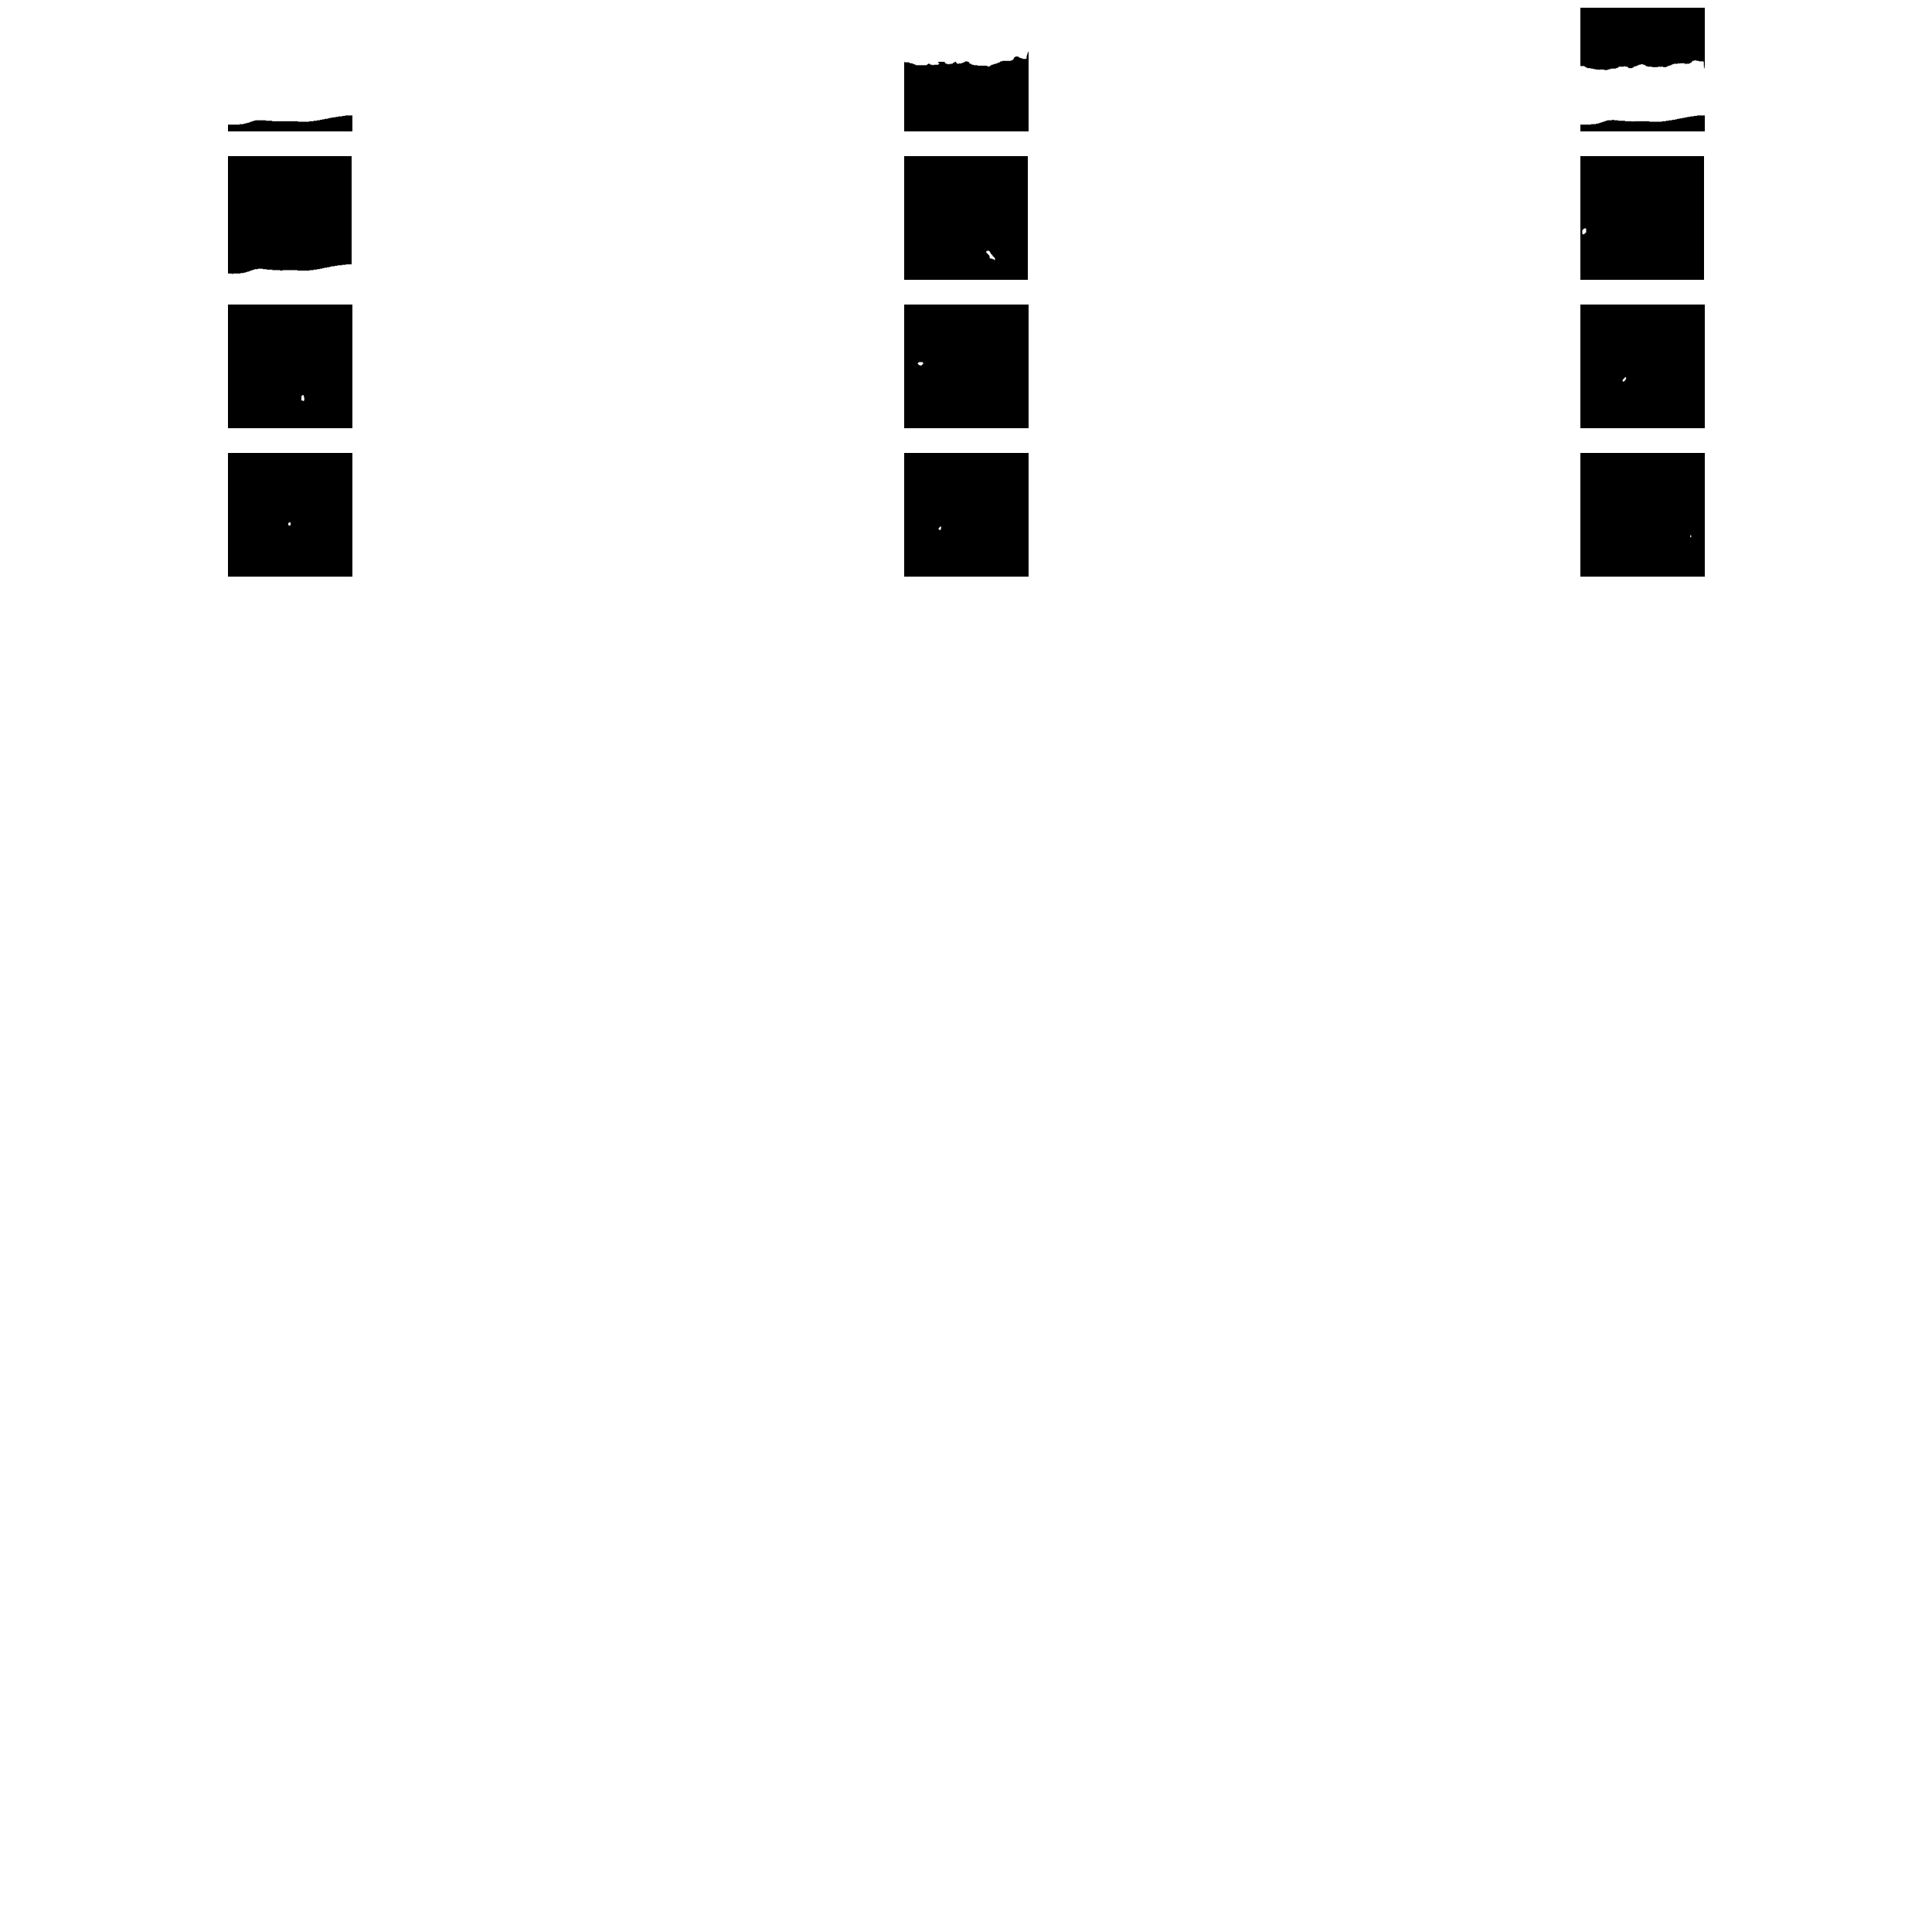

In [ ]:
boolean_masks = [
    masks2['segmentation']
    for masks2
    in sorted(masks2, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=boolean_masks,
    grid_size=(len(masks), int(len(boolean_masks) / 4)),
    size=(32, 32)
)